### DATA 620  
### Week Ten - Assignment: Document Classification

Shri Tripathi  
4/15/2025

#### Assignment Overview

It can be useful to be able to classify new "test" documents using already classified "training" documents.  A common example is using a corpus of labeled spam and ham (non-spam) e-mails to predict whether or not a new document is spam.  Here is one example of such data:  [UCI Machine Learning Repository: Spambase Data Set](https://archive.ics.uci.edu/dataset/94/spambase)

For this project, you can either use the above dataset to predict the class of new documents (either withheld from the training dataset or from another source such as your own spam folder). For more adventurous students, you are welcome (encouraged!) to come up a different set of documents (including scraped web pages!?) that have already been classified (e.g. tagged), then analyze these documents to predict how new documents should be classified.

#### Project Description

In this assignment, the goal is to create a spam detection classifier that predicts whether an email is spam or ham using a separate set of pre-classified documents. The spam and ham corpora for this project can be obtained from the SpamAssassin public corpus available here:  
[SpamAssassin Public Corpus](http://spamassassin.apache.org/old/publiccorpus/).

The code provided in your project assumes that the following tarball files have been downloaded, unzipped, and untarred in a local directory:

* `20021010_hard_ham.tar.bz2` &mdash; contains ham emails (notoriously more challenging to categorize)
* `20021010_spam.tar.bz2` &mdash; contains spam emails
* `20030228_hard_ham.tar.bz2` &mdash; contains ham emails (used as a test set for the classifier)
* `20030228_spam.tar.bz2` &mdash; contains spam emails

After extracting these files, the directory structure should be as follows (all email files should reside in the lowest subdirectory):

* `./20021010_hard_ham/hard_ham`
* `./20030228_hard_ham/hard_ham`
* `./spam`
* `./20030228_spam/spam`

### General Approach for the Spam Detection Classifier

1. **Load the Data**: Import spam and ham email messages from the specified directories.
2. **Preprocess and Feature Extraction**: Clean the emails and extract relevant features (e.g., term frequencies, n-grams).
3. **Train the Classifier**: Use the processed training data to build the classification model.
4. **Evaluate the Classifier**: Test the model’s performance using an evaluation set.
5. **Model Selection**: Compare different classifiers and tune hyperparameters.
6. **Prediction**: Finally, use the selected classifier to predict the class of new emails, especially focusing on the ham emails for further validation.

### Import Necessary Packages

In [1]:
import nltk
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from nltk import word_tokenize, WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import NaiveBayesClassifier, classify
from nltk import DecisionTreeClassifier, classify
from nltk import MaxentClassifier, classify
from collections import Counter

import numpy  
import pandas as pd
import random
import string
import itertools

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC


### Step 1 - Load Ham and Spam Email Messages as Corpora





In [ ]:
# Define a function that processes files in a given directory and produces
# three essential outputs for subsequent analysis:
#   1. A PlaintextCorpusReader instance from nltk.corpus.reader.plaintext.
#   2. An nltk.text.Text object containing tokenized sentences.
#   3. A list of emails each labeled with either ham or spam.

def init_corpus(dir, tag):
    
    # Apply latin-1 encoding to correctly handle special characters.
    # Create a PlaintextCorpusReader to read every file in the specified directory.
    corpus0 = PlaintextCorpusReader(dir, '.*', encoding='latin-1') 
    
    # Extract and tokenize the sentences from the corpus.
    # This produces an nltk.Text object with the tokenized sentence data.
    corpus  = nltk.Text(corpus0.sents())
    
    # Assign the provided tag to each email, preparing the data for later classification.
    emails = [(email, tag) for email in corpus]
    
    return corpus0, corpus, emails


In [ ]:
## Ham Email Corpus
## Initialize using a subset of ham emails known to be particularly challenging
## These emails have been identified as more complex to classify
## =====================================================================
hamcorpusdir = './20021010_hard_ham/hard_ham'   # directory path for the ham emails

hamcorpus0, hamcorpus, ham_emails = init_corpus(hamcorpusdir, 'ham')


In [ ]:
## Spam Email Corpus
## Set up the corpus for spam emails using the designated directory
## ================================================================
spamcorpusdir = './spam'  # Path to the local directory containing spam emails

spamcorpus0, spamcorpus, spam_emails = init_corpus(spamcorpusdir, 'spam')


#### Produce Overview Statistics for the Corpora

In [ ]:
def corpus_stats(corpus, name):
    # Calculate the total number of files in the corpus.
    total_files = len(corpus.fileids())
    
    # Compute the total number of characters in the corpus's raw text.
    total_chars = len(corpus.raw())
    
    # Compute the total number of words in the corpus.
    total_words = len(corpus.words())
    
    # Compute the total number of sentences in the corpus.
    total_sentences = len(corpus.sents())

    # Print a header for the corpus statistics using the provided name.
    print("{} Corpus: ".format(name))
    print("===========================")
    
    # Display the total number of files.
    print("Total Files = {}".format(total_files))
    
    # Display the total number of words.
    print("Total Words = {}".format(total_words))
    
    # Calculate and display the average number of words per file.
    print("Avg Words Per File = {}".format(total_words / total_files))
    
    # Display the total number of sentences.
    print("Total Sentences = {}".format(total_sentences))
    
    # Calculate and display the average number of sentences per file.
    print("Avg Sentences Per File = {}".format(total_sentences / total_files))


In [6]:
corpus_stats(spamcorpus0, "Spam Corpus")

Spam Corpus Corpus: 
Total Files = 501
Total Words = 769207
Avg Words Per File = 1535
Total Sentences = 12107
Avg Sentences Per File = 24


In [7]:
corpus_stats(hamcorpus0, "Ham Corpus")

Ham Corpus Corpus: 
Total Files = 250
Total Words = 1513630
Avg Words Per File = 6054
Total Sentences = 24035
Avg Sentences Per File = 96


#### Merge the spam and ham email datasets and randomize their order
Set a fixed random seed to ensure that the shuffling produces the same results each time

In [8]:
# combine
random_seed=1534678
random.seed(random_seed)

# combine the spam and ham emails together
all_emails = spam_emails + ham_emails

In [9]:
# shuffle the combined emails
random.shuffle(all_emails)

### Step 2 - Data Preprocessing & Feature Extraction  
Before extracting features, we'll normalize the data to consolidate different forms of the same word into a unified representation. This process involves several techniques including lemmatization, stemming, and the removal of stopwords and punctuation.

In [ ]:

# Optionally, define a stoplist if needed.
# stoplist = stopwords.words("english")

# Function to preprocess a sentence by converting each word to lowercase
# and then applying lemmatization to obtain the base form of each word.
def preprocess1(sentence):
    wnl = WordNetLemmatizer()
    return [wnl.lemmatize(word.lower()) for word in sentence]

# Function to preprocess a sentence using stemming.
# Each word is first converted to lowercase, then reduced to its stem using the Porter stemmer.
def preprocess2(sentence):   
    porter = nltk.PorterStemmer()  
    return [porter.stem(word.lower()) for word in sentence]

def preprocess3(sentence):
    """
    Processes a string of text by performing the following steps:
    1. Remove all punctuation marks.
    2. Eliminate common stopwords.
    3. Return a list of the filtered words.
    """
    # Iterate through the text and remove punctuation characters.
    nopunc = [char for char in sentence if char not in string.punctuation]

    # Join the list of characters back into a full string.
    nopunc = ''.join(nopunc)
    
    # Split the string into words and filter out any stopwords.
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]


### Feature Extraction

In this phase, we will explore three different approaches to build feature sets for the classification model training. Later, in the evaluation stage, we will assess which method delivers the best performance.

In [14]:
stoplist = stopwords.words("english")
## get_features function to extract features
def get_features(text, preprocessor):
    
    """
    Accepts in a string of text and the preprocessing function to be applied
    """
    return {word: True for word in preprocessor(text) if not word in stoplist}

In [15]:
# extract features using the first preprocessor which is using lemmatization
all_features1 = [(get_features(email, preprocess1), label) for (email, label) in all_emails]

In [16]:
# extract features using the second preprocessor which is using stemming
all_features2 = [(get_features(email, preprocess2), label) for (email, label) in all_emails]

In [17]:
# extract features using the third preprocessor which essentially returns cleaned text
all_features3 = [(get_features(email, preprocess3), label) for (email, label) in all_emails]

### Step 3 - Classifier Training

In this stage, we will assess three different types of classifiers. Each employs a unique preprocessing method to generate its respective feature set from the data. The classifiers under evaluation are:

1. Naive Bayes
2. Logistic Regression
3. Linear SVC

In [18]:
## NaiveBayes 
def train_NB(features, samples_proportion):
    train_size = int(len(features) * samples_proportion)
    train_set, test_set = features[:train_size], features[train_size:]
    
    print ('Training set size = ' + str(len(train_set)) + ' emails')
    print ('Test set size = ' + str(len(test_set)) + ' emails')
    
    classifier = NaiveBayesClassifier.train(train_set)
    return train_set, test_set, classifier

## Logistic Regression
def train_LR(features, samples_proportion):
    train_size = int(len(features) * samples_proportion)
    train_set, test_set = features[:train_size], features[train_size:]
    print ('Training set size = ' + str(len(train_set)) + ' emails')
    print ('Test set size = ' + str(len(test_set)) + ' emails')
    
    LogisticRegression_classifier = SklearnClassifier(LogisticRegression())   
    classifier = LogisticRegression_classifier.train(train_set)
    
    return train_set, test_set, classifier

## LinearSVC
def train_LSVC(features, samples_proportion):
    train_size = int(len(features) * samples_proportion)
    train_set, test_set = features[:train_size], features[train_size:]
    print ('Training set size = ' + str(len(train_set)) + ' emails')
    print ('Test set size = ' + str(len(test_set)) + ' emails')
    
    LinearSVC_classifier = SklearnClassifier(LinearSVC())
    classifier = LinearSVC_classifier.train(train_set)
    
    return train_set, test_set, classifier


### Train the NaiveBayes Classifiers

In [19]:
train_set1_NB, test_set1_NB, classifier1_NB = train_NB(all_features1, 0.8)

Training set size = 28913 emails
Test set size = 7229 emails


In [20]:
train_set2_NB, test_set2_NB, classifier2_NB = train_NB(all_features2, 0.8)

Training set size = 28913 emails
Test set size = 7229 emails


In [21]:
train_set3_NB, test_set3_NB, classifier3_NB = train_NB(all_features3, 0.8)

Training set size = 28913 emails
Test set size = 7229 emails


### Train the Logistic Regression Classifiers

In [22]:
train_set1_LR, test_set1_LR, classifier1_LR = train_LR(all_features1, 0.8)

Training set size = 28913 emails
Test set size = 7229 emails


In [23]:
train_set2_LR, test_set2_LR, classifier2_LR = train_LR(all_features2, 0.8)

Training set size = 28913 emails
Test set size = 7229 emails


In [24]:
train_set3_LR, test_set3_LR, classifier3_LR = train_LR(all_features3, 0.8)

Training set size = 28913 emails
Test set size = 7229 emails


### Train the Linear SVC Classifiers

In [25]:
train_set1_LSVC, test_set1_LSVC, classifier1_LSVC = train_LSVC(all_features1, 0.8)

Training set size = 28913 emails
Test set size = 7229 emails


In [26]:
train_set2_LSVC, test_set2_LSVC, classifier2_LSVC = train_LSVC(all_features2, 0.8)

Training set size = 28913 emails
Test set size = 7229 emails


In [27]:
train_set3_LSVC, test_set3_LSVC, classifier3_LSVC = train_LSVC(all_features3, 0.8)

Training set size = 28913 emails
Test set size = 7229 emails


### Step 4 - Evaluate the Classifiers

In [28]:
# Code here for the confusion is heavily borrowed from our 620 group project
def plot_confusion_matrix(cm, classes,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    Plots the confusion matrix. 
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if False else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    return

In [29]:
def evaluate_classifier(train_set, test_set, classifier, preprocessor):
    print("Classifier Performance Evaluation")
    print("===================================\n")
    
    print('Accuracy on the training set = ' + str(classify.accuracy(classifier, train_set)))
    print('Accuracy of the test set = ' + str(classify.accuracy(classifier, test_set)))
    
    ## TRAIN ##
    # create predicted classes (train)
    train_set_predictions = [classifier.classify(get_features(email, preprocessor)) for (email, label) in train_set]
    
    # extract actual classes (gold)
    train_set_gold = [tag for (n, tag) in train_set]
    
    # create confusion matrix
    train_confusion_matrix=confusion_matrix(train_set_gold, train_set_predictions)
    
    # create table with precision, recall, f1-score, and support
    train_report=classification_report(train_set_gold, train_set_predictions, digits=4)
    
    # display performance report (train)
    print('\nModel Performance Metrics (Train):')
    print(train_report)
    
    #----------------------------------------------------------------------------------
    ## TEST ##
    # create predicted classes (test)
    test_set_predictions = [classifier.classify(get_features(email, preprocessor)) for (email, label) in test_set]
    
    # extract actual classes (gold)
    test_set_gold = [tag for (n, tag) in test_set]
    
    # create confusion matrix
    test_confusion_matrix=confusion_matrix(test_set_gold, test_set_predictions)
           
    # create table with precision, recall, f1-score, and support
    test_report=classification_report(test_set_gold, test_set_predictions, digits=4)
    
    # display performance report (train)
    print('\nModel Performance Metrics (Test):')
    print(test_report)
    
    ## Confusion Matrices - Test vs. Train side-by-side
    # size figure
    plt.figure(figsize=(10,6))
    # add first subplot
    plt.subplot(2, 2, 1)
    # plot confusion matrix
    plot_confusion_matrix(train_confusion_matrix, classes=['spam','ham'], title="Confusion Matrix - Training Set")
    # add second subplot
    plt.subplot(2, 2, 2)
    # plot confusion matrix (test)
    plot_confusion_matrix(test_confusion_matrix, classes=['spam','ham'], title="Confusion Matrix - Test Set")
    
    return 

### NaiveBayes Evaluation

Classifier Performance Evaluation

Accuracy on the training set = 0.904921661536
Accuracy of the test set = 0.872181491216

Model Performance Metrics (Train):
             precision    recall  f1-score   support

        ham     0.9346    0.9218    0.9282     19263
       spam     0.8481    0.8713    0.8595      9650

avg / total     0.9057    0.9050    0.9053     28913


Model Performance Metrics (Test):
             precision    recall  f1-score   support

        ham     0.9104    0.8946    0.9024      4772
       spam     0.8020    0.8291    0.8153      2457

avg / total     0.8736    0.8723    0.8728      7229



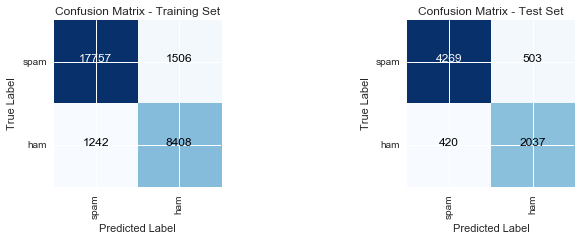

In [30]:
# preprocessing of features based on lemmatization
evaluate_classifier(train_set1_NB, test_set1_NB, classifier1_NB, preprocess1)

Classifier Performance Evaluation

Accuracy on the training set = 0.893196831875
Accuracy of the test set = 0.865818232121

Model Performance Metrics (Train):
             precision    recall  f1-score   support

        ham     0.9276    0.9070    0.9172     19263
       spam     0.8222    0.8587    0.8400      9650

avg / total     0.8924    0.8908    0.8914     28913


Model Performance Metrics (Test):
             precision    recall  f1-score   support

        ham     0.9060    0.8843    0.8950      4772
       spam     0.7853    0.8217    0.8031      2457

avg / total     0.8650    0.8631    0.8638      7229



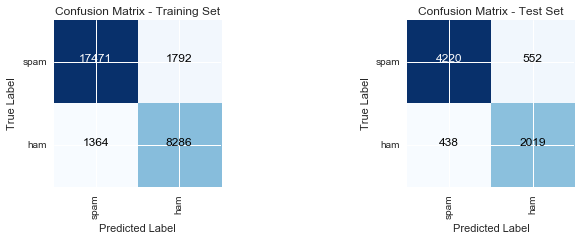

In [31]:
# preprocessing of features based on stemming
evaluate_classifier(train_set2_NB, test_set2_NB, classifier2_NB, preprocess2)

Classifier Performance Evaluation

Accuracy on the training set = 0.989174419811
Accuracy of the test set = 0.823488725965

Model Performance Metrics (Train):
             precision    recall  f1-score   support

        ham     0.9857    0.9982    0.9919     19263
       spam     0.9964    0.9711    0.9836      9650

avg / total     0.9893    0.9892    0.9891     28913


Model Performance Metrics (Test):
             precision    recall  f1-score   support

        ham     0.7905    0.9969    0.8817      4772
       spam     0.9876    0.4868    0.6521      2457

avg / total     0.8575    0.8235    0.8037      7229



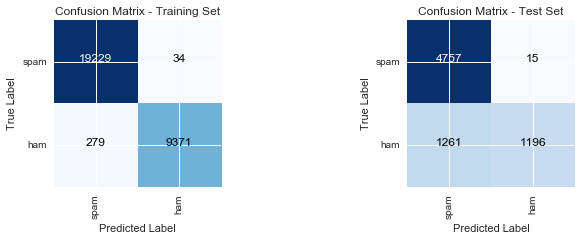

In [32]:
# preprocessing of features based on cleaned Text -- removal of punctuation, stopwords.  
evaluate_classifier(train_set3_NB, test_set3_NB, classifier3_NB, preprocess3)

__Note__ The featureset based on the the third preprocessing option appear to be overfitting the training dataset.  The peformance metrics against the test dataset show some marked degradation.  Consequently, we'll discontinue using this in subsequent classifiers.

### Logistic Regression Evaluation

Classifier Performance Evaluation

Accuracy on the training set = 0.95925708159
Accuracy of the test set = 0.913819338774

Model Performance Metrics (Train):
             precision    recall  f1-score   support

        ham     0.9600    0.9796    0.9697     19263
       spam     0.9575    0.9184    0.9376      9650

avg / total     0.9592    0.9592    0.9590     28913


Model Performance Metrics (Test):
             precision    recall  f1-score   support

        ham     0.9249    0.9466    0.9356      4772
       spam     0.8913    0.8506    0.8705      2457

avg / total     0.9134    0.9140    0.9135      7229



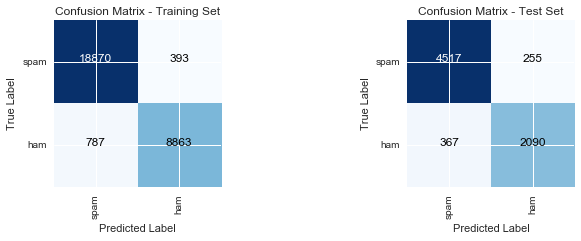

In [33]:
# preprocessing of features based on lemmatization
evaluate_classifier(train_set1_LR, test_set1_LR, classifier1_LR, preprocess1)

Classifier Performance Evaluation

Accuracy on the training set = 0.953135267873
Accuracy of the test set = 0.911744362982

Model Performance Metrics (Train):
             precision    recall  f1-score   support

        ham     0.9518    0.9740    0.9628     19263
       spam     0.9455    0.9016    0.9230      9650

avg / total     0.9497    0.9498    0.9495     28913


Model Performance Metrics (Test):
             precision    recall  f1-score   support

        ham     0.9214    0.9436    0.9324      4772
       spam     0.8851    0.8437    0.8639      2457

avg / total     0.9091    0.9097    0.9091      7229



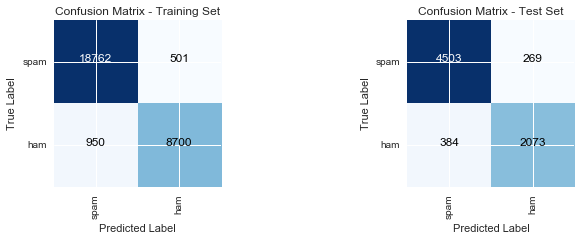

In [34]:
# preprocessing of features based on stemming
evaluate_classifier(train_set2_LR, test_set2_LR, classifier2_LR, preprocess2)

### Linear SVC Evaluation

Classifier Performance Evaluation

Accuracy on the training set = 0.97859094525
Accuracy of the test set = 0.917139300041

Model Performance Metrics (Train):
             precision    recall  f1-score   support

        ham     0.9799    0.9874    0.9836     19263
       spam     0.9745    0.9595    0.9669      9650

avg / total     0.9781    0.9781    0.9781     28913


Model Performance Metrics (Test):
             precision    recall  f1-score   support

        ham     0.9377    0.9361    0.9369      4772
       spam     0.8763    0.8791    0.8777      2457

avg / total     0.9168    0.9167    0.9168      7229



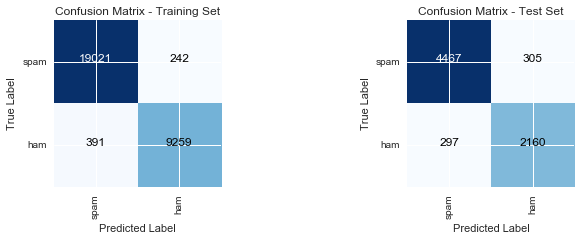

In [35]:
# preprocessing of features based on lemmatization
evaluate_classifier(train_set1_LSVC, test_set1_LSVC, classifier1_LSVC, preprocess1)

Classifier Performance Evaluation

Accuracy on the training set = 0.972987929305
Accuracy of the test set = 0.913542675335

Model Performance Metrics (Train):
             precision    recall  f1-score   support

        ham     0.9702    0.9842    0.9771     19263
       spam     0.9675    0.9397    0.9534      9650

avg / total     0.9693    0.9693    0.9692     28913


Model Performance Metrics (Test):
             precision    recall  f1-score   support

        ham     0.9313    0.9348    0.9331      4772
       spam     0.8725    0.8661    0.8693      2457

avg / total     0.9113    0.9115    0.9114      7229



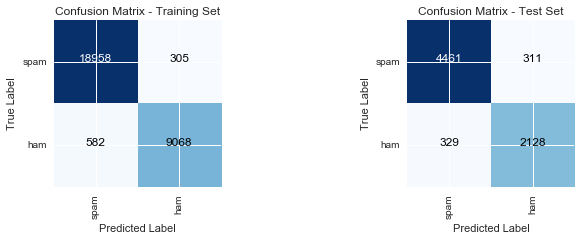

In [36]:
# preprocessing of features based on stemming
evaluate_classifier(train_set2_LSVC, test_set2_LSVC, classifier2_LSVC, preprocess2)

## Conclusion

After evaluating the three classifiers, the LinearSVC classifier—combined with lemmatization-based feature selection—demonstrated the best performance when measured by the f1-score on the test dataset.

Next, we will analyze the classifier's performance on a subset of ham emails known to be more challenging to categorize. This focused test will reveal whether the classifier mistakenly labels any of these difficult ham messages as spam.

In [37]:
## Ham Email Messages 
## ========================

hardhamcorpusdir = './20030228_hard_ham/hard_ham/'   # local directory structure of the ham emails
hardhamcorpus0, hardhamcorpus, hard_ham_emails = init_corpus(hardhamcorpusdir, 'ham')

In [38]:
predictions = [classifier2_LSVC.classify(get_features(email, preprocess1)) for (email, label) in hard_ham_emails]

In [39]:
Counter(predictions), len(predictions)

(Counter({'ham': 21375, 'spam': 1660}), 23035)

__For the ham messages—using a new, more challenging set of ham—the classifier correctly identified 92.7% as ham. Given this strong performance with ham emails, the LinearSVC classifier appears to be a promising choice for ham classification.__

__How does it perform when it comes to detecting spam?__

Let's check against known spam as second commparison

In [40]:
## Spam Email Messages 
## ========================

spam2corpusdir = './20030228_spam/spam/'   # local directory structure of the ham emails
spam2corpus0, spam2corpus, spam2_emails = init_corpus(spam2corpusdir, 'spam')

In [41]:
predictions = [classifier2_LSVC.classify(get_features(email, preprocess1)) for (email, label) in spam2_emails]

In [42]:
Counter(predictions), len(predictions)

(Counter({'ham': 2389, 'spam': 9637}), 12026)

__Of the spam messages, the classifier correctly identified 80% as spam. Considering these results, further model tuning—especially focused on spam detection—would be a crucial next step.__


In summary, the document classification project set out to build a robust spam detection system by comparing three different classifiers—Naive Bayes, Logistic Regression, and Linear SVC—each paired with a unique preprocessing approach. Among these, the Linear SVC classifier, particularly when used in combination with lemmatization for feature extraction, demonstrated the most promising results. The evaluation revealed that while the classifier correctly identified 92.7% of the more challenging ham emails, its performance on spam emails was somewhat lower, with an 80% accuracy rate. These findings underscore the effectiveness of the chosen preprocessing strategy for ham classification while also highlighting the need for further fine-tuning and model optimization to enhance spam detection accuracy.

Going forward, additional refinements such as exploring alternative feature extraction methods, incorporating more sophisticated algorithms, or even combining classifiers could help mitigate the misclassification of spam. Overall, the project illustrates the critical role of both preprocessing and model selection in developing a reliable email classification system, and it sets a strong foundation for future improvements.